# CNN Scaling Analysis for Hyperspectral Unmixing

This notebook summarizes training dynamics for multiple 1D CNN model sizes
(M, L, XL) trained for per-pixel hyperspectral unmixing.

We analyze:
- train vs validation MSE over epochs (log scale)
- learning rate schedules (log scale)
- evidence for convergence vs overfitting

All curves are generated from saved training logs (`history.csv`).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

runs_root = Path("runs")

seed = 42

sizes = ["m", "l", "xl"]

def find_latest_run_dir(prefix: str) -> Path | None:
    """
    Finds the most recent run folder in runs/ that starts with prefix.
    Example prefix: "cnn_m_seed42" or "cnn_m"
    """
    candidates = [p for p in runs_root.iterdir() if p.is_dir() and p.name.startswith(prefix)]
    if not candidates:
        return None
    candidates.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates[0]

# first prefers "cnn_m_seed42..." naming, otherwise falls back to "cnn_m..."
run_dirs = {}
for s in sizes:
    preferred_prefix = f"cnn_{s}_seed{seed}"
    fallback_prefix = f"cnn_{s}"

    d = find_latest_run_dir(preferred_prefix)
    if d is None:
        d = find_latest_run_dir(fallback_prefix)

    run_dirs[s] = d

run_dirs

{'m': PosixPath('runs/cnn_m_seed42_20260118_214329_seed42'),
 'l': PosixPath('runs/cnn_l_seed42_20260118_233601_seed42'),
 'xl': PosixPath('runs/cnn_xl_seed42_20260119_011515_seed42')}

In [3]:
def make_curves(run_dir: Path):
    hist_path = run_dir / "history.csv"
    if not hist_path.exists():
        print("missing history.csv:", hist_path)
        return

    df = pd.read_csv(hist_path)

    # loss curve (log)
    plt.figure()
    plt.plot(df["epoch"], df["train_mse"], label="train MSE")
    plt.plot(df["epoch"], df["val_mse"], label="val MSE")
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("MSE (log scale)")
    plt.title(run_dir.name)
    plt.legend()
    plt.tight_layout()
    plt.savefig(run_dir / "loss_curve_log.png", dpi=200)
    plt.close()

    # lr curve (log)
    plt.figure()
    plt.plot(df["epoch"], df["lr"])
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("learning rate (log scale)")
    plt.title(run_dir.name)
    plt.tight_layout()
    plt.savefig(run_dir / "lr_curve.png", dpi=200)
    plt.close()

    print("saved plots for", run_dir.name)

for s, d in run_dirs.items():
    if d is None:
        print("missing run dir for size:", s)
        continue
    make_curves(d)

print("done")

saved plots for cnn_m_seed42_20260118_214329_seed42
saved plots for cnn_l_seed42_20260118_233601_seed42
saved plots for cnn_xl_seed42_20260119_011515_seed42
done



 cnn_m_seed42_20260118_214329_seed42


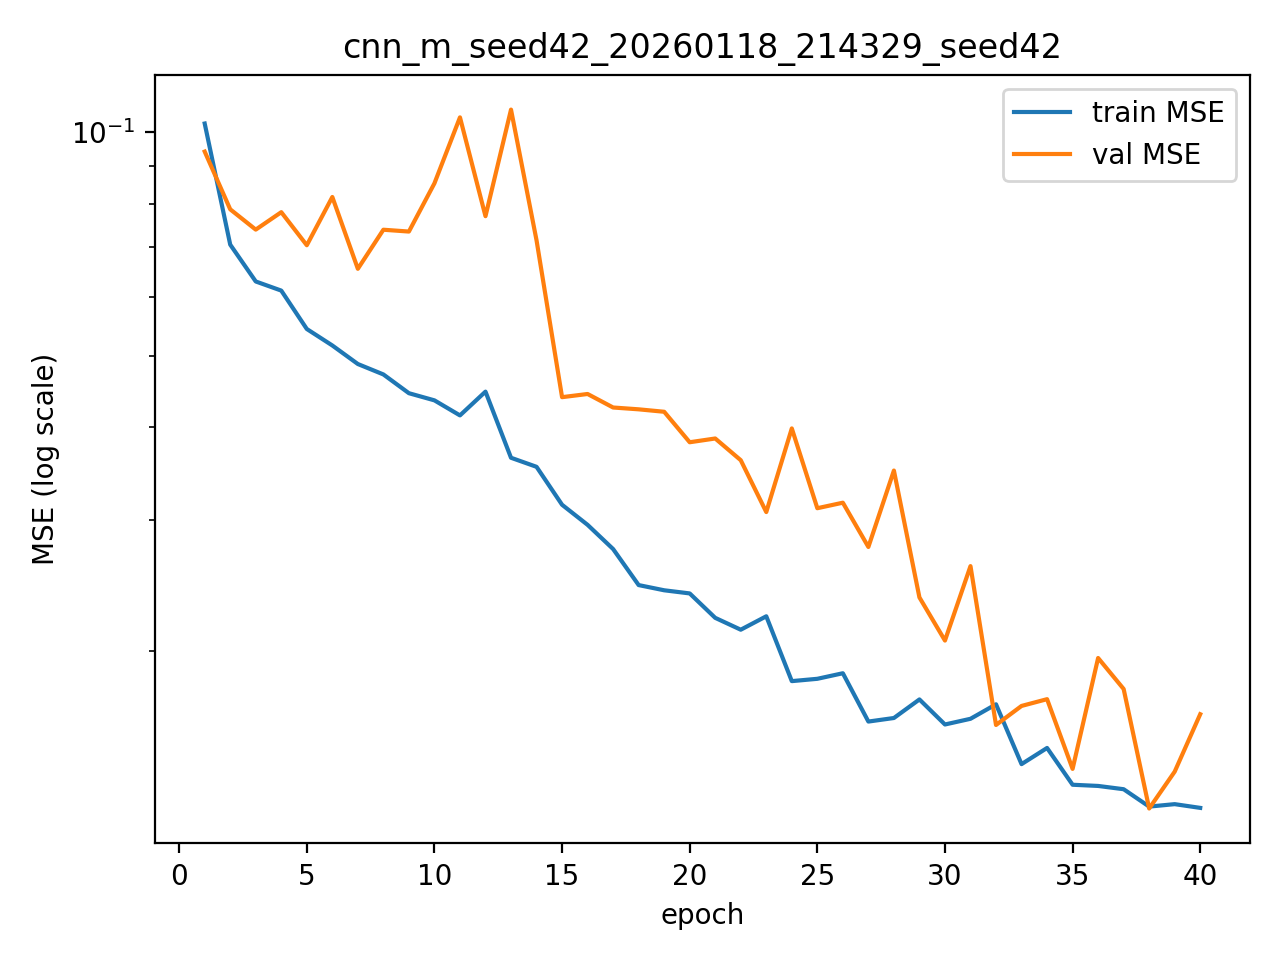


 cnn_l_seed42_20260118_233601_seed42


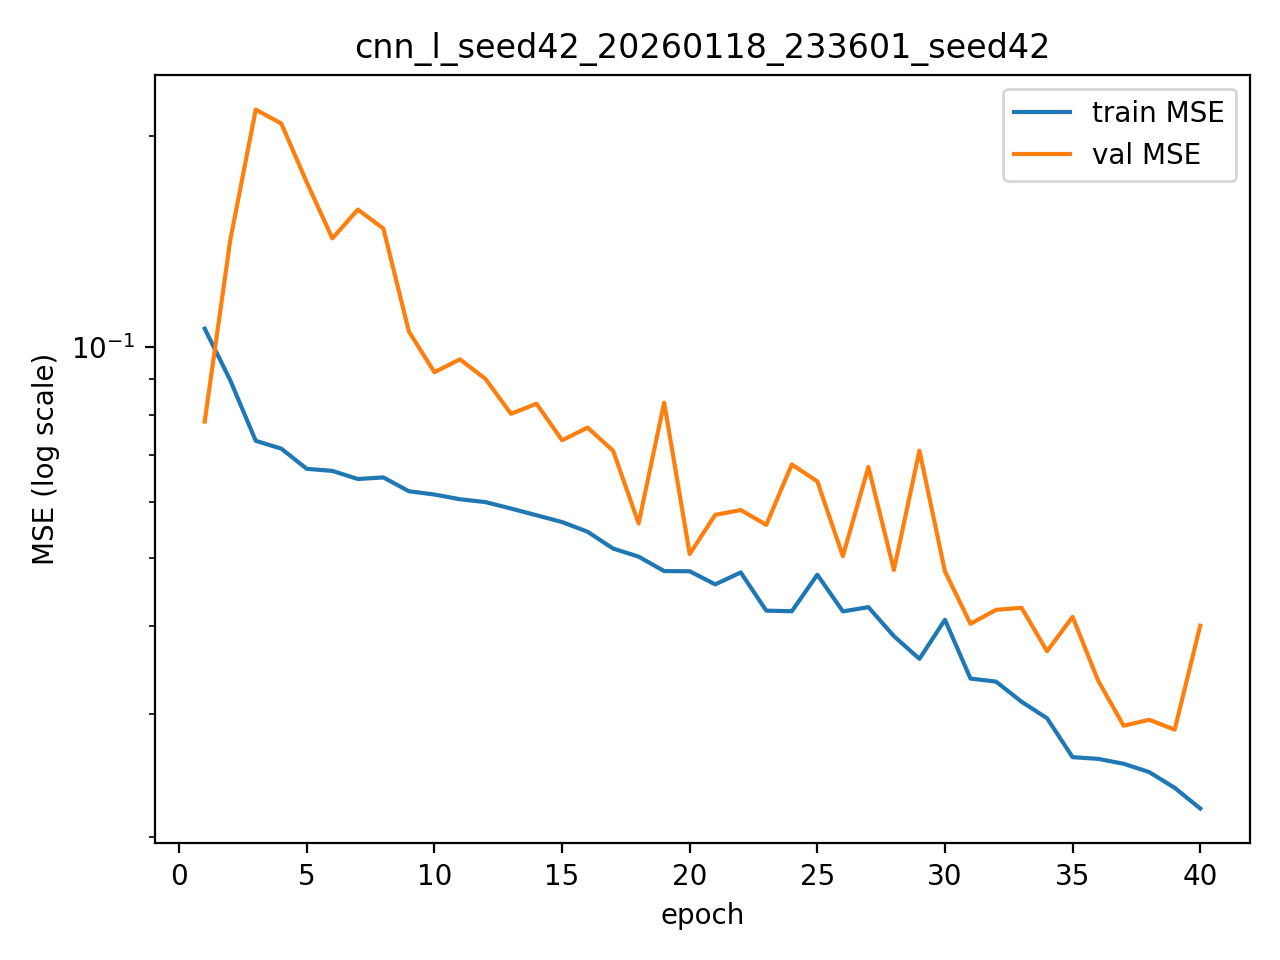


 cnn_xl_seed42_20260119_011515_seed42


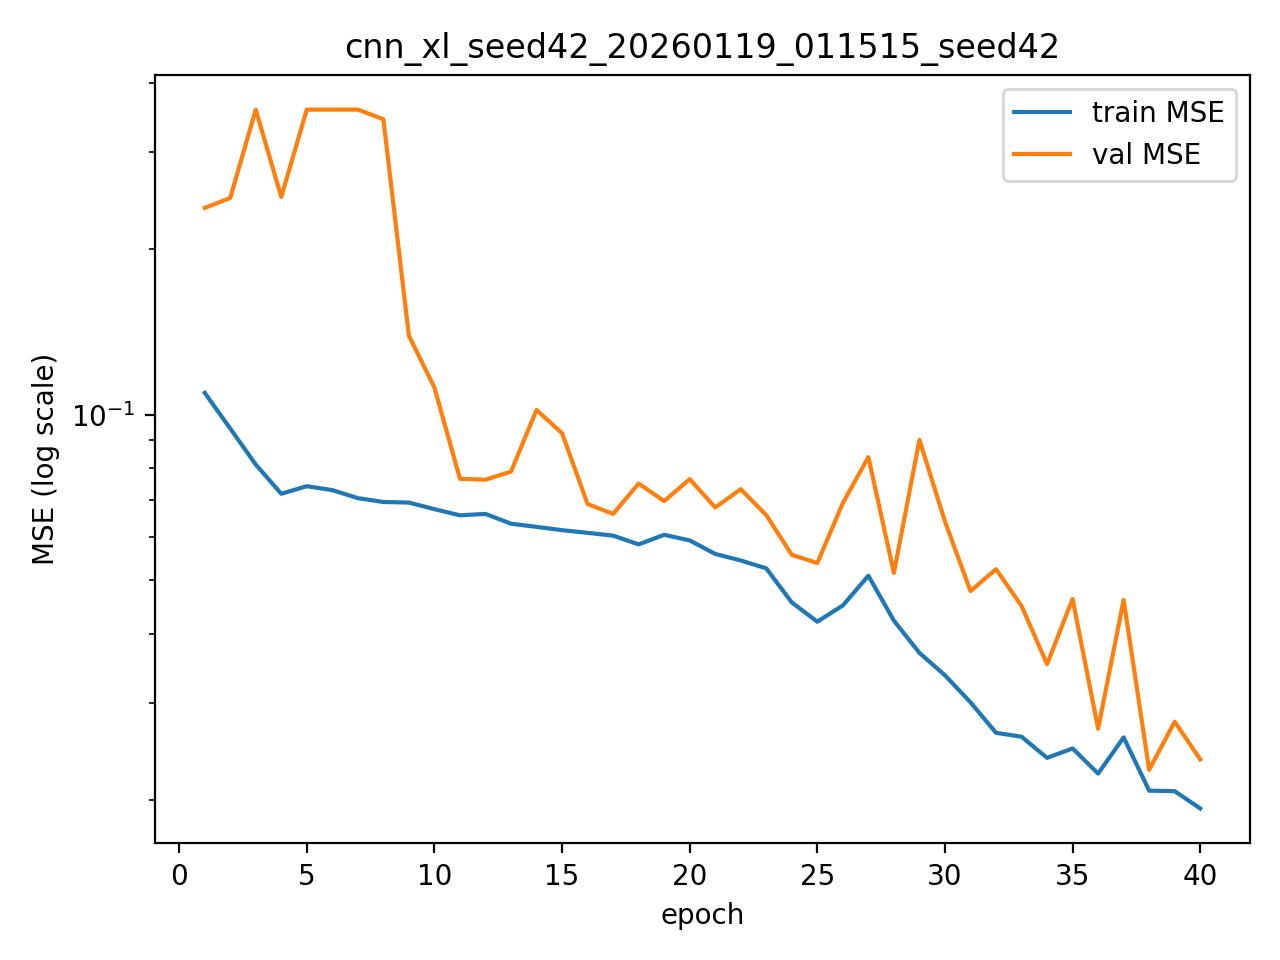

In [4]:
from IPython.display import Image, display

for s, d in run_dirs.items():
    if d is None:
        continue
    print("\n", d.name)
    display(Image(filename=str(d / "loss_curve_log.png")))


 cnn_m_seed42_20260118_214329_seed42


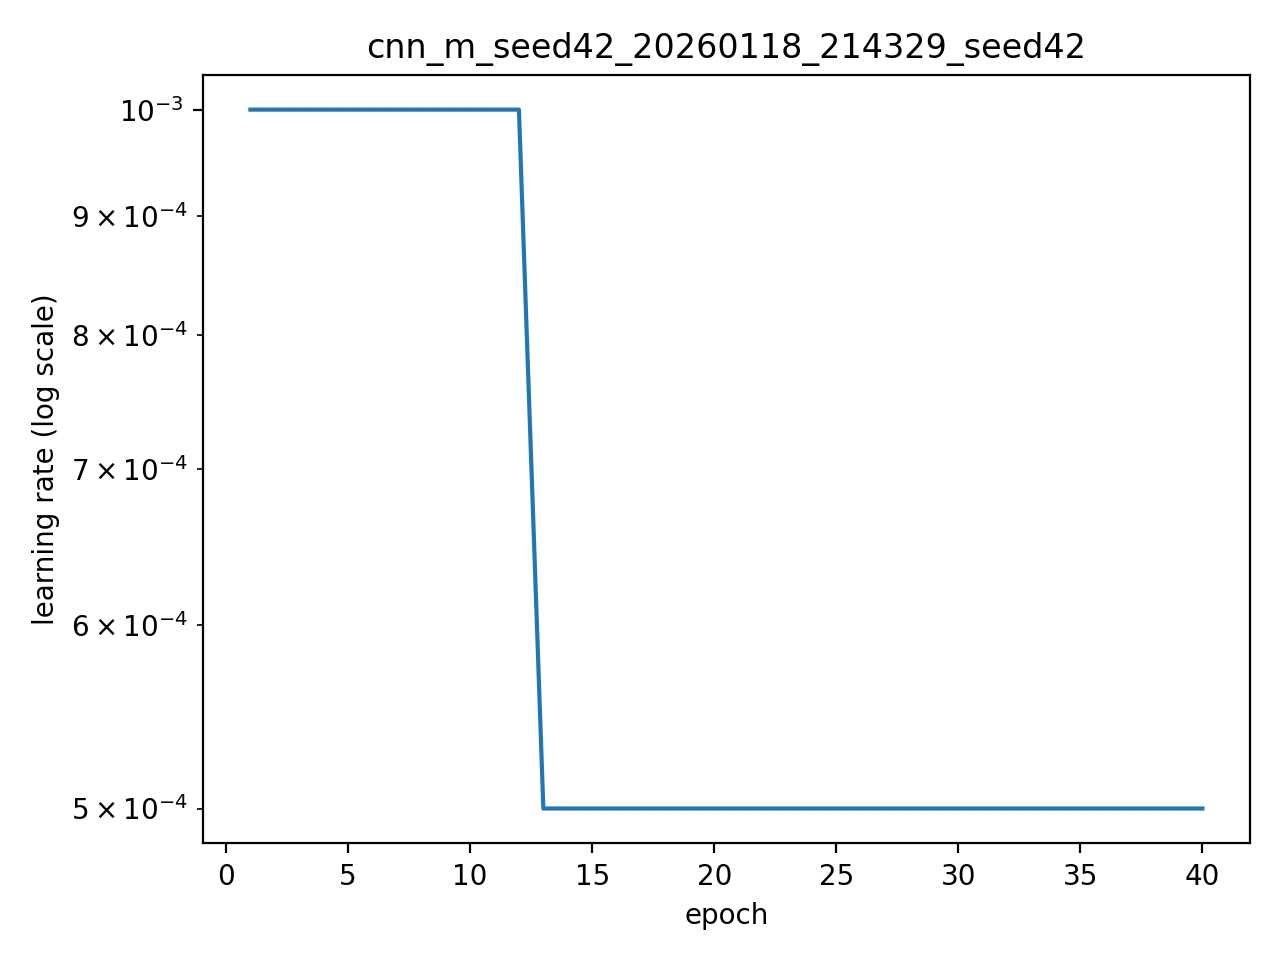


 cnn_l_seed42_20260118_233601_seed42


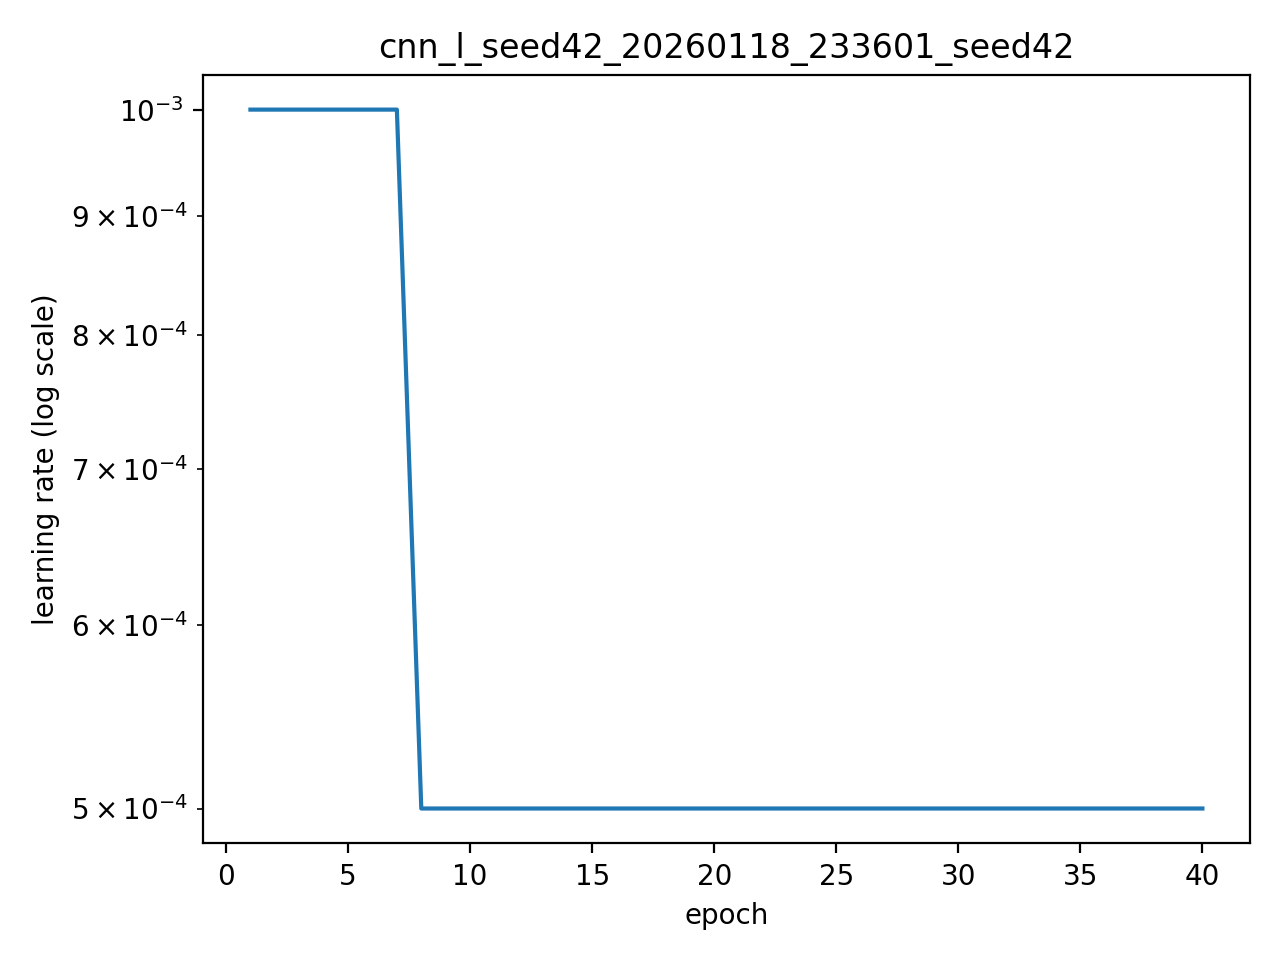


 cnn_xl_seed42_20260119_011515_seed42


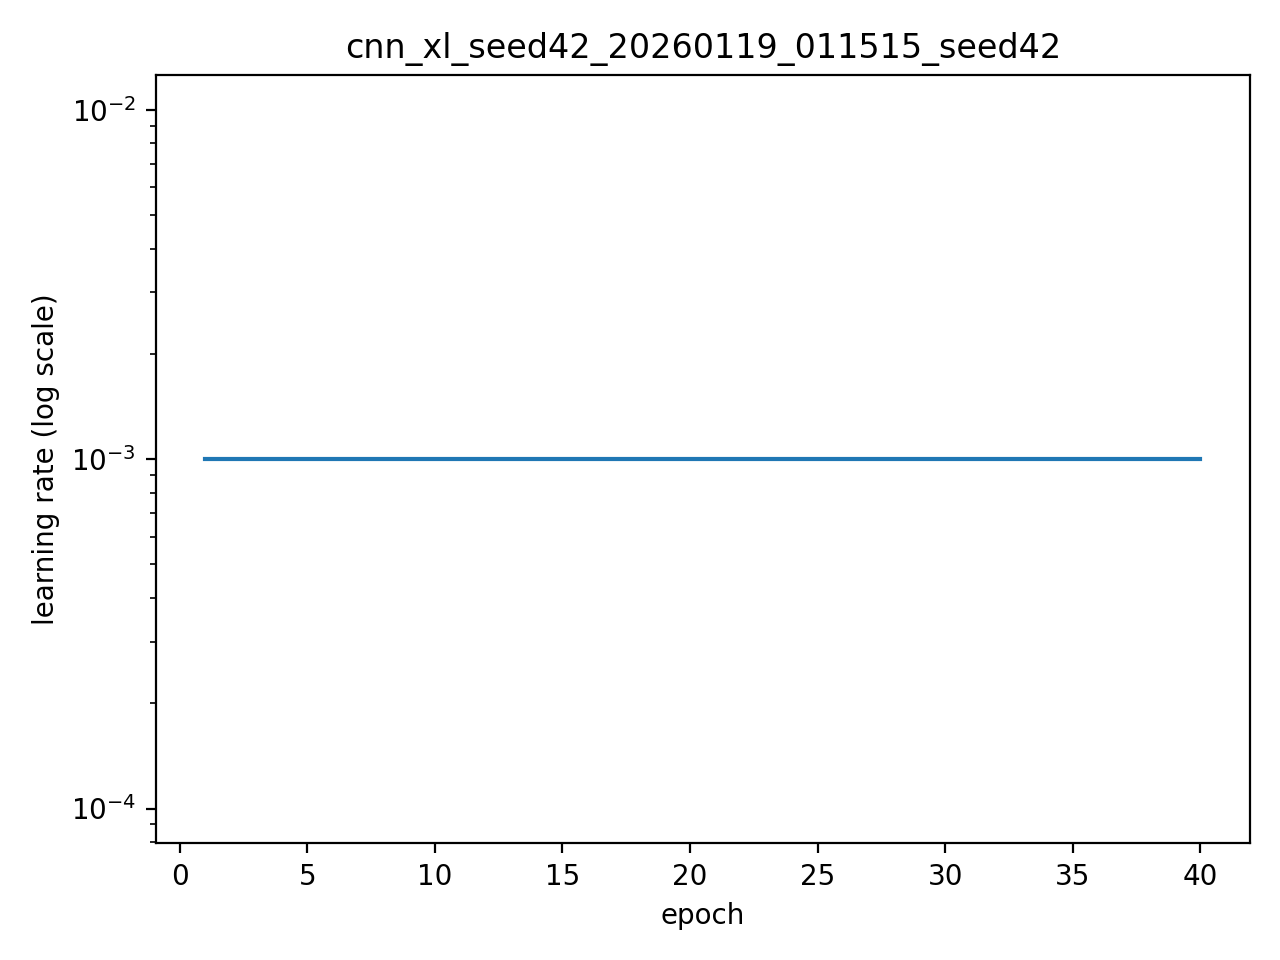

In [5]:
from IPython.display import Image, display

for s, d in run_dirs.items():
    if d is None:
        continue
    print("\n", d.name)
    display(Image(filename=str(d / "lr_curve.png")))

In [6]:
import json

rows = []
for s, d in run_dirs.items():
    if d is None:
        continue

    summary_path = d / "summary.json"
    if not summary_path.exists():
        print("missing summary.json:", summary_path)
        continue

    with open(summary_path, "r") as f:
        summary = json.load(f)

    rows.append({
        "size": s.upper(),
        "run_dir": d.name,
        "best_epoch": summary.get("best_epoch"),
        "best_val_mse": summary.get("best_val_mse"),
        "train_mse_at_best": summary.get("train_mse_at_best"),
        "val_mse_at_best": summary.get("val_mse_at_best"),
        "test_mse": summary.get("test_mse"),
        "val_r2": summary.get("val_r2"),
        "test_r2": summary.get("test_r2"),
        "generalization_gap": summary.get("generalization_gap"),
        "epochs_ran": summary.get("epochs_ran"),
    })

results_df = pd.DataFrame(rows).sort_values("size")
results_df

,size,run_dir,best_epoch,best_val_mse,train_mse_at_best,val_mse_at_best,test_mse,val_r2,test_r2,generalization_gap,epochs_ran
1,L,cnn_l_seed42_20260118_233601_seed42,39,0.028469,0.027132,0.028469,0.029462,0.695789,0.667156,0.001336,40
0,M,cnn_m_seed42_20260118_214329_seed42,38,0.012248,0.013235,0.012248,0.015718,0.865952,0.816944,-0.000987,40
2,XL,cnn_xl_seed42_20260119_011515_seed42,38,0.022662,0.024854,0.022662,0.021657,0.746673,0.745797,-0.002192,40


In [7]:
results_df.to_csv("cnn_scaling_summary_seed42.csv", index=False)

## Interpretation (CNN, 40 epochs, seed42)

- **cnn-m smoked the others.** it’s the clear best run:
  - best val MSE = **0.012248**
  - test MSE = **0.015718**
  - test R² = **0.8169**
  L and XL aren’t close (val MSE ~0.0285 for L, ~0.0227 for XL).

- **scaling did *not* help here (M → L → XL).** bigger cnn didn’t buy better performance, it actually got worse. so unlike the fno story, cnn scaling right now is different.

*used chatgpt for the rest*:

- **generalization gap is tiny (even negative for M and XL).** so this doesn’t scream “overfitting.” if anything it suggests:
  - dropout/batchnorm making train error a bit noisy,
  - or train/val split difficulty differences,
  - or just evaluation mode quirks.
  but basically: **not a big overfit problem** in these runs.

- **40 epochs might be cutting things off early.** all three runs had best epoch at **38–39 / 40**, which is a huge hint the models were still improving when we hit the epoch cap. so:
  - cnn-m already got good fast
  - cnn-l / cnn-xl might need more time *and/or* better hyperparams to actually benefit from their size

- **most likely issue for L/XL = optimization / hyperparams, not capacity.** since they’re worse even on train-ish metrics (and gaps aren’t exploding), it’s less “too big so it overfits” and more “this setup isn’t letting the bigger models shine” (lr, dropout, weight decay, schedule, or just too few epochs).

---

## CNN vs FNO (quick compare)

- **FNO results:** scaling helped a lot from tiny → mid, then diminishing returns. bigger models fit train much better but validation gains were smaller, and the gap tended to grow → looks like overfitting pressure + diminishing returns.

- **CNN results (this run):** opposite vibe. **cnn-m is best**, and going bigger **hurts** (within 40 epochs), without a clear “gap grows with size” pattern. so for cnn, the current story is:
  > **cnn-m is a strong baseline (test R² ~0.82). cnn-l/xl aren’t worth it yet unless we tune or train longer.**
